In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Rutgers_FDM_Group_Project/

Mounted at /content/drive
/content/drive/MyDrive/Rutgers_FDM_Group_Project


In [2]:
!pip install emoji --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 35.2 MB/s eta 0:00:00


In [3]:
import zipfile
import re
import string


import emoji

import pandas as pd
pd.set_option('display.max_colwidth', 200000)

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from scipy.sparse import hstack
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, StandardScaler
import joblib

In [4]:
zf = zipfile.ZipFile('processed_data.csv.zip')
trec_data = pd.read_csv(zf.open('processed_data.csv'))
trec_data['source'] = 'trec'
trec_data = trec_data[['source','message', 'label']]


enron_data = pd.read_csv('enron_spam_data.csv')
enron_data['Spam/Ham'] = enron_data['Spam/Ham'].map({'spam': 1, 'ham': 0})
enron_data['source'] = 'enron'
enron_data.rename(columns={'Spam/Ham': 'label'}, inplace=True)
enron_data.rename(columns={'Message': 'message'}, inplace=True)
enron_data = enron_data[['source','message', 'label']]

spamAssassin_data = pd.read_parquet('0000.parquet')
spamAssassin_data['label'] = spamAssassin_data['group'].map({'easy_ham': 0, 'easy_ham_2': 0, 'hard_ham':0, 'spam' :1, 'spam_2':1})
spamAssassin_data['source'] = 'spamAssassin'
spamAssassin_data.rename(columns={'text': 'message'}, inplace=True)
spamAssassin_data = spamAssassin_data[['source','message', 'label']]

print(trec_data.shape)
print(enron_data.shape)
print(spamAssassin_data.shape)

(75419, 3)
(33716, 3)
(10749, 3)


In [5]:
print(trec_data.label.value_counts())
print(enron_data.label.value_counts())
print(spamAssassin_data.label.value_counts())

label
1    50199
0    25220
Name: count, dtype: int64
label
1    17171
0    16545
Name: count, dtype: int64
label
0    6954
1    3795
Name: count, dtype: int64


In [6]:
!pip install wordfreq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.5 MB/s eta 0:00:00


In [7]:
import spacy
import re

In [8]:
# extract important features from emails
from wordfreq import word_frequency

def is_real_english_word(word, lang='en', threshold=1e-16):
    return (
        word_frequency(word.lower(), lang) > threshold
        # or word.lower() in custom_vocab
    )

def is_real_french_word(word, lang='fr', threshold=1e-16):
    return (
        word_frequency(word.lower(), lang) > threshold
        # or word.lower() in custom_vocab
    )

def extract_handcrafted_features(email_text):
    """
    Extract handcrafted features for spam detection.
    """
    features = {}

    # All caps words
    features['num_all_caps'] = len(re.findall(r'\b[A-Z]{2,}\b', email_text))

    # Obfuscated words (ex: fr33, c@sh, etc.)
    suspicious = set()
    obfuscated_matches = re.findall(r'\b[a-zA-Z0-9]*[@$0-9][a-zA-Z0-9]*\b', email_text) # detect obfuscate words like fr33, v1agra, c@sh
    suspicious.update(obfuscated_matches)
    clean_text = email_text
    for word in obfuscated_matches:
        clean_text = clean_text.replace(word, '')

    # Step 3: Tokenize clean text into normal words
    tokens = re.findall(r'\b[a-zA-Z]{3,}\b', clean_text)
    for word in tokens:
        if not is_real_english_word(word) and not is_real_french_word(word):
            suspicious.add(word) # detect misspelled words or gibberish words or non-english words like fre, offrr, monay, fjksd, asd123x
    features['num_obfuscated_words'] = len(suspicious)

    # Currency mentions
    features['num_currency_mentions'] = len(re.findall(r'[\$€£₹¥]|USD|EUR|GBP|INR|YEN', email_text, re.IGNORECASE))

    # Emoji count
    features['num_emojis'] = len([c for c in email_text if c in emoji.EMOJI_DATA])

    # Phone number mentions
    features['num_phone_numbers'] = len(re.findall(r'\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b', email_text))

    # URL mentions
    features['num_urls'] = len(re.findall(r'https?://\S+|ftp://\S+|www\.\S+', email_text))

    return features

import spacy
import re


nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Define mapping from placeholder to temp safe tokens
PLACEHOLDER_MAP = {
    "<EMAIL>": "PH_EMAIL",
    "<URL>": "PH_URL",
    "<PHONE>": "PH_PHONE",
    "<NUMBER>": "PH_NUMBER",
    "<CURRENCY>": "PH_CURRENCY",
    "<DATE>": "PH_DATE",
    "<EMOJI>": "PH_EMOJI"
}

# Reverse map to restore later
REVERSE_PLACEHOLDER_MAP = {v: k for k, v in PLACEHOLDER_MAP.items()}

def lemmatize_text(text):
    # Replace placeholders with safe spaCy-friendly tokens
    for placeholder, replacement in PLACEHOLDER_MAP.items():
        text = text.replace(placeholder, replacement)

    # Lemmatize using spaCy
    tokens = []
    for token in nlp(text):
        token_text = token.text

        # Restore placeholders
        if token_text in REVERSE_PLACEHOLDER_MAP:
            tokens.append(REVERSE_PLACEHOLDER_MAP[token_text])
        elif token.is_alpha and not token.is_stop:
            tokens.append(token.lemma_)

    return ' '.join(tokens)

# Function to clean the raw email to embedding-friendly emails
def prepare_clean_text_for_embedding(email_text):
    """
    Clean the email while preserving contextual signals via special tokens.
    """
    # Convert to lowercase
    text = email_text.lower()

    # text = lemmatize_text(text)

    # words = text.split()

    # Filter valid English or French words only
    # valid_words = [word for word in words if is_real_english_word(word) or is_real_french_word(word)]

    # Return cleaned text
    # text = " ".join(valid_words)

    text = re.sub(r'\\n+', ' ', text)

    # Replace URLs and emails
    text = re.sub(r'https?://\S+|ftp://\S+|www\.\S+', ' <URL> ', text)
    text = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', ' <EMAIL> ', text)

    # Replace phone numbers
    text = re.sub(r'\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b', ' <PHONE> ', text)

    # Remove phone numbers and extensions
    text = re.sub(r'(\(?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4})', ' ', text)
    text = re.sub(r'ext\.?\s?\d+', ' ', text)

    text = re.sub(r'\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}[+-]\d{2}:\d{2}', ' <DATE> ', text)

    # Replace currency symbols
    text = re.sub(r'[\$€£₹¥]', ' <CURRENCY> ', text)
    text = re.sub(r'\b(?:usd|eur|gbp|inr|yen)\b', ' <CURRENCY> ', text, flags=re.IGNORECASE)

    # Replace numbers
    text = re.sub(r'\b\d+(?:[.,]\d+)?\b', ' <NUMBER> ', text)

    # Remove emoji (or keep if using emoji embeddings)
    text = ''.join([ch if ch not in emoji.EMOJI_DATA else ' <EMOJI> ' for ch in text])

    # Remove forwarded lines / metadata
    # text = re.sub(r'(-{2,}|forwarded by|subject:.*|from:.*|to:.*|cc:.*|original message|unsubscribe.*|trouble\? contact.*)', ' ', text, flags=re.IGNORECASE)

    # Remove long sequences of dashes or underscores
    text = re.sub(r'[-_]{2,}', ' ', text)

    # Remove non-ASCII characters
    text = text.encode('ascii', errors='ignore').decode()

    # Remove tables or repeated pipe structures
    text = re.sub(r'\|.*?\|', ' ', text)
    text = re.sub(r'\n\s*\|', ' ', text)

    # Remove excessive punctuation or long token bursts
    # text = re.sub(r'[^\w\s<>\']', ' ', text)
    text = re.sub(r'([!?.])\1{2,}', ' ', text)

    # Remove words of length <= 2 characters
    text = re.sub(r'\b\w{1,2}\b', '', text)

    # Collapse whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    text = lemmatize_text(text)

    return text.strip()

def vectorize_features(feature_dict):
    """
    Convert feature dictionary to numpy vector or DataFrame row.
    """
    return pd.DataFrame([feature_dict])


def process_email(email_text):
    """
    Complete pipeline: takes raw email → returns cleaned text and features.
    """
    email_text = str(email_text) if not isinstance(email_text, str) else email_text
    cleaned_text = prepare_clean_text_for_embedding(email_text)
    features = extract_handcrafted_features(email_text)
    feature_vector = vectorize_features(features)
    return cleaned_text, feature_vector


In [9]:

def create_clean_and_featured_df(df, email_col='message'):
    df = df.reset_index(drop=True)  # Ensure clean index

    cleaned_texts = []
    feature_vectors = []

    for text in df[email_col]:
        # Handle non-string values gracefully
        if not isinstance(text, str):
            text = ""

        # Cleaned email for embedding
        cleaned = prepare_clean_text_for_embedding(text)
        cleaned_texts.append(cleaned)

        # Extract features
        features_dict = extract_handcrafted_features(text)
        feature_df = vectorize_features(features_dict)

        # Extract the row from feature_df (assumes single row)
        feature_vectors.append(feature_df.iloc[0])

    # Add cleaned text
    df['cleaned_text'] = cleaned_texts

    # Build feature DataFrame and reset index
    features_combined_df = pd.DataFrame(feature_vectors).reset_index(drop=True)

    # Combine with main DataFrame
    df_final = pd.concat([df.reset_index(drop=True), features_combined_df], axis=1)

    return df_final


In [37]:
# print(trec_data['message'][1])

# a = prepare_clean_text_for_embedding(trec_data['message'][1])

# print(a)

In [38]:
trec_data_final = create_clean_and_featured_df(trec_data)
trec_data_final.head(2)

source  \
0   trec   
1   trec   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             message  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Content-Type: text/html;\nContent-Transfer-Encoding: 7Bit Do you feel the pressure to perform and not rising to the occasion?? Try V ia gr a ..... your anxiety will be a thing of the past and you will be back to your old self.   
1  Hi, i've just updated from the gulus and I check on other mirrors.\nIt seems there is a little typo in /debian/README file\n\nExample:\nhttp://gulus.usherbrooke.ca/debian/README\nftp://ftp.fr.debian.org/debian/README\n\n"Testing, or lenny.  Access this release through dists/testing.  The\ncurrent tested development snapshot is named etch.  Packages which\nhave been tested in unstable and passed automated tests propogate to\nthis release."\n\netch should be replace by lenny like in the README.html\n\n\n\n-- \nYan Morin\nConsultant en logiciel libre\nyan.morin@savoirfairelinux.com\n514-994-1556\n\n\n-- \nTo UNSUBSCRIBE, email to debian-mirrors-REQUEST@lists.debian.org\nwith a subject of "unsubscribe". Trouble? Contact listmaster@lists.debian.org   

   label  \
0      1   
1      0   

                                                                                                                                                                                                                                                                                                                                                               cleaned_text  \
0                                                                                                                                                                                                                                                      content type text html content transfer encoding feel pressure perform rise occasion try anxiety thing past old self   
1  update gulus check mirror little typo readme file example <URL> <URL> testing lenny access release dist testing current test development snapshot name etch package test unstable pass automate test propogate release etch replace lenny like yan morin consultant logiciel libre <EMAIL> <PHONE> unsubscribe email <EMAIL> subject unsubscribe trouble contact <EMAIL>   

   num_all_caps  num_obfuscated_words  num_currency_mentions  num_emojis  \
0             0                     1                      0           0   
1             6                     9                      0           0   

   num_phone_numbers  num_urls  
0                  0         0  
1                  1         2

In [39]:
trec_data_final.to_csv('trec_data_final_2.csv', index=False)


In [40]:
enron_data_final = create_clean_and_featured_df(enron_data, 'message')
enron_data_final = enron_data_final.dropna()
enron_data_final.to_csv('enron_data_final_2.csv', index=False)

enron_data_final.head(2)

source  \
1  enron   
2  enron   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [41]:
spamAssassin_data_final = create_clean_and_featured_df(spamAssassin_data, 'message')
spamAssassin_data_final = spamAssassin_data_final.dropna()
spamAssassin_data_final.to_csv('spamAssassin_data_final_2.csv', index=False)

spamAssassin_data_final.head(2)

source  \
0  spamAssassin   
1  spamAssassin   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   message  \
0  "\n> From: fork-admin@xent.com [mailto:fork-admin@xent.com] On Behalf Of\nJames\n> Rogers\n\n> Subject: Re: The Curse of India's Socialism\n> \n> On Tue, 2002-08-20 at 15:01, Ian Andrew Bell wrote:\n\n> > They\n> > finished their routine with the a quadruple lutz -- laying off\n> > hundreds of thousands of workers when it all came crashing down.\n> \n> So what?  Nobody is guaranteed employment.  Laying people off is not a\n> crime nor is it immoral.  Companies don't exist to provide employment,\n> nor should they.  The closest we have to such a thing in the US is a\n> Government Job, and look at the quality THAT breeds.\n\nAnd further, why focus on the fact they were laid off and not on the\nfact they were hired in the first place?\n\nBTW: I saw someone claim that aside from the efficiency of the market\nthere were also gains to society from irrational behavior.\n\nIf a society has business people that systematically overestimate their\nchances, that is bad for the businessmen but on net a big gain for\nsociety.  On the social level, the law of averages works to societies\nbenefit in a manner it can't for an individual.\n\nA key reason, in this view, that the US wound up outperforming England\nwas that the English investors were too rational for their societies own\ngood.\n\n(Except, of course, when US investors were bilking them to build canals\nand railroads over here.  Thanks, guys.)\n\n=====================\n\nApplied to telecom: a lot of dark wire (glass) and innovation will\neventually be used for pennies on the dollar, the benefits to society\nand the costs to the investors.\n\n\n\n\n\n\n"   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 "Hi,\n\nOn Sun, 01 Sep 2002 00:05:03 MDT Reg Clem

In [10]:
trec_data_final = pd.read_csv('trec_data_final_2.csv')

print(trec_data_final.shape)


(75419, 10)


In [11]:
spamAssassin_data_final = pd.read_csv('spamAssassin_data_final_2.csv')

print(spamAssassin_data_final.shape)


(10749, 10)


In [12]:
enron_data_final = pd.read_csv('enron_data_final_2.csv')

print(enron_data_final.shape)


(33345, 10)


In [ ]:
def unique_words(df, column_name):
    """
    Returns a set of unique words from a specified column in a Pandas DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the column to extract unique words from.

    Returns:
        set: A set containing the unique words.
    """
    all_words = []
    for text in df[column_name].astype(str):
        words = text.lower().split()
        all_words.extend(words)
    return set(all_words)

unique_words_set = unique_words(trec_data_final, 'cleaned_text')

len(unique_words_set)

2797662

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    trec_data_final['cleaned_text'], trec_data_final['label'], test_size=0.2, stratify=trec_data_final['label'], random_state=42
)

In [ ]:

# Define pipeline with bi-gram TF-IDF vectorizer, chi2 selector, and classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        token_pattern=r'<[^>]+>|\b\w+\b',
        lowercase=True,
        ngram_range=(2, 2)  # Use only bi-grams
    )),
    ('chi2', SelectKBest(score_func=chi2)),
    ('clf', LogisticRegression(
        solver='liblinear',
        max_iter=1000,
        class_weight='balanced'
    ))
])

# Define parameter grid
param_grid = {
    'tfidf__ngram_range': [(1, 1), (2, 2)],
    'tfidf__min_df': [2],
    'tfidf__max_df': [0.95],
    'tfidf__max_features': [500, 1000, 2000, 3000, 5000, 10000],
    'chi2__k': [500, 1000, 3000, 5000]
    # 'clf__C': [0.01, 0.1, 1.0]
}

# Define stratified cross-validation and F1 scorer
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score)

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring=scorer,
    verbose=1,
    n_jobs=-1
)

# Fit the model to training data
grid_search.fit(X_train, y_train)

# Print best parameters and F1 score
print("Best Params:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Save best model and full grid search results
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

import os
joblib.dump(best_model, os.path.join('Models','trec_final_tfidf_LG.joblib'))
joblib.dump(grid_search, os.path.join('Models','gridsearch_trec_tfidf_LG.joblib'))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Params: {'chi2__k': 5000, 'tfidf__max_df': 0.95, 'tfidf__max_features': 5000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}
Best F1 Score: 0.9917913268542733


['Models/gridsearch_trec_tfidf_LG.joblib']

In [ ]:
best_model = joblib.load(os.path.join('Models','trec_final_tfidf_LG.joblib'))

y_pred = best_model.predict(X_test)

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9926
Recall: 0.9912
F1 Score: 0.9919


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    trec_data_final.drop(columns=['cleaned_text', 'label','source','message']), trec_data_final['label'], test_size=0.2, stratify=trec_data_final['label'], random_state=42
)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

# Simple selector for handcrafted columns
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, keys):
        self.keys = keys

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.keys].values

# Define handcrafted feature columns
feature_cols = trec_data_final.drop(columns=['cleaned_text', 'label', 'source', 'message']).columns.tolist()

# Pipeline for handcrafted features only
pipeline = Pipeline([
    ('selector', FeatureSelector(feature_cols)),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced'))
])

# Parameter grid for logistic regression
param_grid = {
    'clf__C': [0.01, 0.1, 1.0, 10.0]
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score)

# Grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=scorer, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Output
print("Best Params:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Save best model and full grid search results
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

import os
joblib.dump(best_model, os.path.join('Models','trec_final_features_LG.joblib'))
joblib.dump(grid_search, os.path.join('Models','gridsearch_trec_features_LG.joblib'))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Params: {'clf__C': 1.0}
Best F1 Score: 0.7594579500505361


['Models/gridsearch_trec_features_LG.joblib']

In [ ]:
best_model = joblib.load(os.path.join('Models','trec_final_features_LG.joblib'))

y_pred = best_model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.7619
Recall: 0.7424
F1 Score: 0.7520


### Naive Bayes Model Performance

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    trec_data_final['cleaned_text'], trec_data_final['label'], test_size=0.2, stratify=trec_data_final['label'], random_state=42
)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

# Pipeline: TF-IDF → Naive Bayes
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        token_pattern=r'<[^>]+>|\b\w+\b',
        lowercase=True,
        stop_words='english'
    )),
    ('clf', MultinomialNB())
])

# Parameter grid
param_grid = {
    'tfidf__ngram_range': [(1, 1),(2,2)],
    'tfidf__min_df': [3],
    'tfidf__max_df': [0.95],
    'tfidf__max_features': [1000, 3000, 5000, 10000, 20000],
    'clf__alpha': [0.5, 1.0]  # Smoothing parameter
}

# Scoring and cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score)


# Grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring=scorer,
    verbose=1,
    n_jobs=-1
)

# Fit
grid_search.fit(X_train, y_train)

# Results
print("Best Params:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)


# Save best model and full grid search results
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

import os
joblib.dump(best_model, os.path.join('Models','trec_final_features_NB.joblib'))
joblib.dump(grid_search, os.path.join('Models','gridsearch_trec_features_NB.joblib'))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'clf__alpha': 0.5, 'tfidf__max_df': 0.95, 'tfidf__max_features': 20000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (2, 2)}
Best F1 Score: 0.9845280177204249


['Models/gridsearch_trec_features_NB.joblib']

In [ ]:
best_model = joblib.load(os.path.join('Models','trec_final_features_NB.joblib'))

y_pred = best_model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9887
Recall: 0.9772
F1 Score: 0.9829


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    trec_data_final.drop(columns=['cleaned_text', 'label','source','message']), trec_data_final['label'], test_size=0.2, stratify=trec_data_final['label'], random_state=42
)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

# Define custom selector for handcrafted features
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, keys):
        self.keys = keys

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.keys].values

# Define handcrafted feature column names
feature_cols = trec_data_final.drop(columns=['cleaned_text', 'label', 'source', 'message']).columns.tolist()

# Setup pipeline
pipeline = Pipeline([
    ('selector', FeatureSelector(feature_cols)),
    ('scale', StandardScaler(with_mean=False)),  # Naive Bayes can't handle negative values
    ('clf', MultinomialNB())
])

# Grid search parameters
param_grid = {
    'clf__alpha': [0.5, 1.0]
}

# Setup cross-validation and scoring
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score)


# Perform grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring=scorer,
    verbose=1,
    n_jobs=-1
)

# Fit
grid_search.fit(X_train, y_train)

# Results
print("Best Params:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Save best model and full grid search results
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

import os
joblib.dump(best_model, os.path.join('Models','trec_final_features_NB2.joblib'))
joblib.dump(grid_search, os.path.join('Models','gridsearch_trec_features_NB2.joblib'))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Params: {'clf__alpha': 0.5}
Best F1 Score: 0.8149811502768385


['Models/gridsearch_trec_features_NB2.joblib']

In [ ]:
best_model = joblib.load(os.path.join('Models','trec_final_features_NB2.joblib'))

y_pred = best_model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.7211
Recall: 0.9310
F1 Score: 0.8127


### SVM Model Performance

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    trec_data_final['cleaned_text'], trec_data_final['label'], test_size=0.2, stratify=trec_data_final['label'], random_state=42
)

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score


# Define the pipeline: TF-IDF vectorizer + Linear SVM
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        token_pattern=r'<[^>]+>|\b\w+\b',
        lowercase=True,
        stop_words='english'
    )),
    ('clf', LinearSVC(
        class_weight='balanced',  # handles imbalance
        max_iter=10000            # ensures convergence
    ))
])

# Grid of parameters to search
param_grid = {
    'tfidf__ngram_range': [(1, 1), (2, 2)],
    'tfidf__min_df': [3],
    'tfidf__max_df': [0.95],
    'tfidf__max_features': [1000, 5000, 10000, 20000],
    'clf__C': [0.1, 0.5, 1.0]  # regularization strength
}

# Set up cross-validation and scoring metric
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score)

# GridSearchCV to find best parameters
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=scorer,
    verbose=1,
    n_jobs=-1
)

# Fit model
grid_search.fit(X_train, y_train)

# Output best results
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Best model after tuning
best_svm_model = grid_search.best_estimator_


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'clf__C': 0.5, 'tfidf__max_df': 0.95, 'tfidf__max_features': 20000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1)}
Best F1 Score: 0.9958052139441296


KeyError: "None of [Index(['num_all_caps', 'num_obfuscated_words', 'num_currency_mentions',\n       'num_emojis', 'num_phone_numbers', 'num_urls'],\n      dtype='object')] are in the [index]"

In [ ]:
best_svm_model.fit(X_train, y_train)

import os
joblib.dump(best_svm_model, os.path.join('Models','trec_final_tfidf_SVM.joblib'))
joblib.dump(grid_search, os.path.join('Models','gridsearch_trec_tfidf_SVM.joblib'))

['Models/gridsearch_trec_tfidf_SVM.joblib']

In [ ]:
best_model = joblib.load(os.path.join('Models','trec_final_tfidf_SVM.joblib'))

y_pred = best_model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9962
Recall: 0.9945
F1 Score: 0.9954


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    trec_data_final.drop(columns=['cleaned_text', 'label','source','message']), trec_data_final['label'], test_size=0.2, stratify=trec_data_final['label'], random_state=42
)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Define handcrafted feature columns
feature_cols = trec_data_final.drop(columns=['cleaned_text', 'label', 'source', 'message']).columns.tolist()


# Define pipeline: Standardize features + Linear SVM
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('clf', LinearSVC(class_weight='balanced', max_iter=10000))
])

# Define grid of hyperparameters
param_grid = {
    'clf__C': [0.1, 1.0, 5.0]
}

# Stratified 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score)

# GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=scorer,
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Output best results
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Best trained model
best_handcrafted_svm_model = grid_search.best_estimator_
best_handcrafted_svm_model.fit(X_train, y_train)

import os
joblib.dump(best_handcrafted_svm_model, os.path.join('Models','trec_final_features_SVM.joblib'))
joblib.dump(grid_search, os.path.join('Models','gridsearch_trec_features_SVM.joblib'))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'clf__C': 0.1}
Best F1 Score: 0.7660406985219097


['Models/gridsearch_trec_features_SVM.joblib']

In [ ]:
best_model = joblib.load(os.path.join('Models','trec_final_features_SVM.joblib'))

y_pred = best_model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.7511
Recall: 0.7641
F1 Score: 0.7576


### Decision Tree Model Performance

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    trec_data_final['cleaned_text'], trec_data_final['label'], test_size=0.2, stratify=trec_data_final['label'], random_state=42
)

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Define the pipeline: TF-IDF vectorizer + Decision Tree
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        token_pattern=r'<[^>]+>|\b\w+\b',
        lowercase=True,
        stop_words='english'
    )),
    ('clf', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

# Define grid of hyperparameters for tuning
param_grid = {
    'tfidf__ngram_range': [(1, 1)],
    'tfidf__min_df': [3],
    'tfidf__max_df': [0.95],
    'tfidf__max_features': [5000, 7500, 10000, 20000],
    'clf__max_depth': [20, 50, None],
    'clf__min_samples_split': [2],
    'clf__min_samples_leaf': [2]
}

# Define cross-validation and scorer
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score)

# Run GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=scorer,
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Output best results
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Store the best model
best_dt_model = grid_search.best_estimator_
best_dt_model.fit(X_train, y_train)

import os


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'clf__max_depth': 50, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'tfidf__max_df': 0.95, 'tfidf__max_features': 10000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1)}
Best F1 Score: 0.9884847484380488


NameError: name 'joblib' is not defined

In [ ]:
import joblib
joblib.dump(best_dt_model, os.path.join('Models','trec_final_tfidf_DT.joblib'))
joblib.dump(grid_search, os.path.join('Models','gridsearch_trec_tfidf_DT.joblib'))

['Models/gridsearch_trec_tfidf_DT.joblib']

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
best_model = joblib.load(os.path.join('Models','trec_final_tfidf_DT.joblib'))

y_pred = best_model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9903
Recall: 0.9867
F1 Score: 0.9885


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    trec_data_final['cleaned_text'], trec_data_final['label'], test_size=0.2, stratify=trec_data_final['label'], random_state=42
)

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Define the pipeline: TF-IDF vectorizer + Decision Tree
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        token_pattern=r'<[^>]+>|\b\w+\b',
        lowercase=True,
        stop_words='english'
    )),
    ('clf', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

# Define grid of hyperparameters for tuning
param_grid = {
    'tfidf__ngram_range': [(2, 2)],
    'tfidf__min_df': [3],
    'tfidf__max_df': [0.95],
    'tfidf__max_features': [5000, 7500, 10000, 20000],
    'clf__max_depth': [20, 50, None],
    'clf__min_samples_split': [2],
    'clf__min_samples_leaf': [2]
}

# Define cross-validation and scorer
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score)

# Run GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=scorer,
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Output best results
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Store the best model
best_dt_model = grid_search.best_estimator_
best_dt_model.fit(X_train, y_train)

import os
import joblib
joblib.dump(best_dt_model, os.path.join('Models','trec_final_tfidf_DT2.joblib'))
joblib.dump(grid_search, os.path.join('Models','gridsearch_trec_tfidf_DT2.joblib'))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'tfidf__max_df': 0.95, 'tfidf__max_features': 20000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (2, 2)}
Best F1 Score: 0.9838628244778835


['Models/gridsearch_trec_tfidf_DT2.joblib']

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
best_model = joblib.load(os.path.join('Models','trec_final_tfidf_DT2.joblib'))

y_pred = best_model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9797
Recall: 0.9875
F1 Score: 0.9836


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    trec_data_final.drop(columns=['cleaned_text', 'label','source','message']), trec_data_final['label'], test_size=0.2, stratify=trec_data_final['label'], random_state=42
)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Define handcrafted feature columns
feature_cols = trec_data_final.drop(columns=['cleaned_text', 'label', 'source', 'message']).columns.tolist()


# Define pipeline: StandardScaler + Decision Tree Classifier
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

# Define hyperparameter grid for tuning
param_grid = {
    'clf__max_depth': [5, 10, 20, 50, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 5]
}

# Stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score)

# Run GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=scorer,
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Output best results
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Best decision tree model
best_handcrafted_dt_model = grid_search.best_estimator_
best_handcrafted_dt_model.fit(X_train, y_train)

import os
import joblib
joblib.dump(best_handcrafted_dt_model, os.path.join('Models','trec_final_features_DT.joblib'))
joblib.dump(grid_search, os.path.join('Models','gridsearch_trec_features_DT.joblib'))

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best Parameters: {'clf__max_depth': 20, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Best F1 Score: 0.9033783582044215


['Models/gridsearch_trec_features_DT.joblib']

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
best_model = joblib.load(os.path.join('Models','trec_final_features_DT.joblib'))

y_pred = best_model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9232
Recall: 0.8852
F1 Score: 0.9038


### Random Forest Model Performance

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    trec_data_final['cleaned_text'], trec_data_final['label'], test_size=0.2, stratify=trec_data_final['label'], random_state=42
)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score


# Define pipeline: TF-IDF + Random Forest Classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        token_pattern=r'<[^>]+>|\b\w+\b',
        lowercase=True,
        stop_words='english'
    )),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
])

# Define parameter grid for GridSearchCV
param_grid = {
    'tfidf__ngram_range': [(1, 1)],
    'tfidf__min_df': [3],
    'tfidf__max_df': [0.95],
    'tfidf__max_features': [5000, 10000, 20000],
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [20, 50],
    'clf__min_samples_split': [2],
    'clf__min_samples_leaf': [2]
}

# Set up cross-validation and F1 scoring
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score)

# Run GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=scorer,
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Output best results
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Best trained model
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

import os
import joblib
joblib.dump(best_rf_model, os.path.join('Models','trec_final_tfidf_RF.joblib'))
joblib.dump(grid_search, os.path.join('Models','gridsearch_trec_tfidf_RF.joblib'))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'clf__max_depth': 50, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 200, 'tfidf__max_df': 0.95, 'tfidf__max_features': 5000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1)}
Best F1 Score: 0.9939970691177431


['Models/gridsearch_trec_tfidf_RF.joblib']

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
best_model = joblib.load(os.path.join('Models','trec_final_tfidf_RF.joblib'))

y_pred = best_model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9928
Recall: 0.9957
F1 Score: 0.9942


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score


# Define pipeline: TF-IDF + Random Forest Classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        token_pattern=r'<[^>]+>|\b\w+\b',
        lowercase=True,
        stop_words='english'
    )),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
])

# Define parameter grid for GridSearchCV
param_grid = {
    'tfidf__ngram_range': [(2, 2)],
    'tfidf__min_df': [3],
    'tfidf__max_df': [0.95],
    'tfidf__max_features': [5000, 10000, 20000],
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [20, 50],
    'clf__min_samples_split': [2],
    'clf__min_samples_leaf': [2]
}

# Set up cross-validation and F1 scoring
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score)

# Run GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=scorer,
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Output best results
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Best trained model
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

import os
import joblib
joblib.dump(best_rf_model, os.path.join('Models','trec_final_tfidf_RF2.joblib'))
joblib.dump(grid_search, os.path.join('Models','gridsearch_trec_tfidf_RF2.joblib'))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'clf__max_depth': 50, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 100, 'tfidf__max_df': 0.95, 'tfidf__max_features': 20000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (2, 2)}
Best F1 Score: 0.9790132927121535


['Models/gridsearch_trec_tfidf_RF2.joblib']

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
best_model = joblib.load(os.path.join('Models','trec_final_tfidf_RF2.joblib'))

y_pred = best_model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9645
Recall: 0.9913
F1 Score: 0.9777


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    trec_data_final.drop(columns=['cleaned_text', 'label','source','message']), trec_data_final['label'], test_size=0.2, stratify=trec_data_final['label'], random_state=42
)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Select only handcrafted feature columns
feature_cols = trec_data_final.drop(columns=['cleaned_text', 'label', 'source', 'message']).columns.tolist()


# Define pipeline: Scaling + Random Forest
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
])

# Define parameter grid
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [10, 20, 50],
    'clf__min_samples_split': [2],
    'clf__min_samples_leaf': [2]
}

# CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score)

# Grid Search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=scorer,
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Output results
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Best model
best_rf_handcrafted_model = grid_search.best_estimator_
best_rf_handcrafted_model.fit(X_train, y_train)

import os
import joblib
joblib.dump(best_rf_handcrafted_model, os.path.join('Models','trec_final_features_RF.joblib'))
joblib.dump(grid_search, os.path.join('Models','gridsearch_trec_features_RF.joblib'))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'clf__max_depth': 50, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Best F1 Score: 0.9081019223434742


['Models/gridsearch_trec_features_RF.joblib']

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
best_model = joblib.load(os.path.join('Models','trec_final_features_RF.joblib'))

y_pred = best_model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9326
Recall: 0.8828
F1 Score: 0.9070


### XGBoost Model Performance

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    trec_data_final['cleaned_text'], trec_data_final['label'], test_size=0.2, stratify=trec_data_final['label'], random_state=42
)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score


# Define pipeline: TF-IDF + XGBoost
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        token_pattern=r'<[^>]+>|\b\w+\b',
        lowercase=True,
        stop_words='english'
    )),
    ('clf', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        objective='binary:logistic',
        n_jobs=2,
        random_state=42,
        scale_pos_weight=1  # adjust manually if strong imbalance
    ))
])

# Grid of hyperparameters
param_grid = {
    'tfidf__ngram_range': [(1, 1)],
    'tfidf__min_df': [2],
    'tfidf__max_df': [0.95],
    'tfidf__max_features': [1000, 3000, 5000],
    'clf__n_estimators': [200],
    'clf__max_depth': [3,6],
    'clf__learning_rate': [0.1],
    'clf__subsample': [0.8],
    'clf__colsample_bytree': [0.8]
}

# Stratified cross-validation
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
scorer = make_scorer(f1_score)

# Run GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=scorer,
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Output results
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Best model
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train, y_train)

import os
import joblib
joblib.dump(best_xgb_model, os.path.join('Models','trec_final_tfidf_XGB.joblib'))
joblib.dump(grid_search, os.path.join('Models','gridsearch_trec_tfidf_XGB.joblib'))

Fitting 4 folds for each of 6 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:08:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 100, 'clf__subsample': 0.8, 'tfidf__max_df': 0.95, 'tfidf__max_features': 5000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}
Best F1 Score: 0.9911975892567264


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:09:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


['Models/gridsearch_trec_tfidf_XGB.joblib']

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
best_model = joblib.load(os.path.join('Models','trec_final_tfidf_XGB.joblib'))

y_pred = best_model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9856
Recall: 0.9965
F1 Score: 0.9910


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score


# Define pipeline: TF-IDF + XGBoost
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        token_pattern=r'<[^>]+>|\b\w+\b',
        lowercase=True,
        stop_words='english'
    )),
    ('clf', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        objective='binary:logistic',
        n_jobs=2,
        random_state=42,
        scale_pos_weight=1  # adjust manually if strong imbalance
    ))
])

# Grid of hyperparameters
param_grid = {
    'tfidf__ngram_range': [(1, 1)],
    'tfidf__min_df': [2],
    'tfidf__max_df': [0.95],
    'tfidf__max_features': [1000, 3000, 5000],
    'clf__n_estimators': [200],
    'clf__max_depth': [10],
    'clf__learning_rate': [0.1],
    'clf__subsample': [0.8],
    'clf__colsample_bytree': [0.8]
}

# Stratified cross-validation
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
scorer = make_scorer(f1_score)

# Run GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=scorer,
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Output results
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Best model
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train, y_train)

import os
import joblib
joblib.dump(best_xgb_model, os.path.join('Models','trec_final_tfidf_XGB2.joblib'))
joblib.dump(grid_search, os.path.join('Models','gridsearch_trec_tfidf_XGB2.joblib'))

Fitting 4 folds for each of 3 candidates, totalling 12 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:17:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.1, 'clf__max_depth': 10, 'clf__n_estimators': 200, 'clf__subsample': 0.8, 'tfidf__max_df': 0.95, 'tfidf__max_features': 3000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}
Best F1 Score: 0.9952175484408969


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:19:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


['Models/gridsearch_trec_tfidf_XGB2.joblib']

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
best_model = joblib.load(os.path.join('Models','trec_final_tfidf_XGB2.joblib'))

y_pred = best_model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9932
Recall: 0.9968
F1 Score: 0.9950


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score


# Define pipeline: TF-IDF + XGBoost
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        token_pattern=r'<[^>]+>|\b\w+\b',
        lowercase=True,
        stop_words='english'
    )),
    ('clf', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        objective='binary:logistic',
        n_jobs=2,
        random_state=42,
        scale_pos_weight=1  # adjust manually if strong imbalance
    ))
])

# Grid of hyperparameters
param_grid = {
    'tfidf__ngram_range': [(2, 2)],
    'tfidf__min_df': [2],
    'tfidf__max_df': [0.95],
    'tfidf__max_features': [1000, 3000, 5000],
    'clf__n_estimators': [200],
    'clf__max_depth': [10],
    'clf__learning_rate': [0.1],
    'clf__subsample': [0.8],
    'clf__colsample_bytree': [0.8]
}

# Stratified cross-validation
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
scorer = make_scorer(f1_score)

# Run GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=scorer,
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Output results
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Best model
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train, y_train)

import os
import joblib
joblib.dump(best_xgb_model, os.path.join('Models','trec_final_tfidf_XGB3.joblib'))
joblib.dump(grid_search, os.path.join('Models','gridsearch_trec_tfidf_XGB3.joblib'))

Fitting 4 folds for each of 3 candidates, totalling 12 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:31:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.1, 'clf__max_depth': 10, 'clf__n_estimators': 200, 'clf__subsample': 0.8, 'tfidf__max_df': 0.95, 'tfidf__max_features': 5000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (2, 2)}
Best F1 Score: 0.9820755379270893


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:33:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


['Models/gridsearch_trec_tfidf_XGB3.joblib']

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
best_model = joblib.load(os.path.join('Models','trec_final_tfidf_XGB3.joblib'))

y_pred = best_model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9698
Recall: 0.9925
F1 Score: 0.9810


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    trec_data_final.drop(columns=['cleaned_text', 'label','source','message']), trec_data_final['label'], test_size=0.2, stratify=trec_data_final['label'], random_state=42
)

In [ ]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Select handcrafted feature columns
feature_cols = trec_data_final.drop(columns=['cleaned_text', 'label', 'source', 'message']).columns.tolist()


# Define pipeline: Standardize + XGBoost
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('clf', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        objective='binary:logistic',
        n_jobs=2,  # Limit for memory safety
        random_state=42,
        scale_pos_weight=1  # Adjust based on class balance if needed
    ))
])

# Grid of hyperparameters (kept tight to avoid memory issues)
param_grid = {
    'clf__n_estimators': [200],
    'clf__max_depth': [3, 6, 10],
    'clf__learning_rate': [0.1, 0.2],
    'clf__subsample': [0.8],
    'clf__colsample_bytree': [0.8]
}

# Define cross-validation and scoring
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score)

# Grid search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=scorer,
    verbose=1,
    n_jobs=2  # Be cautious with memory
)

# Fit the model
grid_search.fit(X_train, y_train)

# Print results
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Best model
best_xgb_handcrafted_model = grid_search.best_estimator_
best_xgb_handcrafted_model.fit(X_train, y_train)

import os
import joblib
joblib.dump(best_xgb_handcrafted_model, os.path.join('Models','trec_final_features_XGB.joblib'))
joblib.dump(grid_search, os.path.join('Models','gridsearch_trec_features_XGB.joblib'))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:46:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.2, 'clf__max_depth': 10, 'clf__n_estimators': 200, 'clf__subsample': 0.8}
Best F1 Score: 0.9168982516654077


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:46:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


['Models/gridsearch_trec_features_XGB.joblib']

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
best_model = joblib.load(os.path.join('Models','trec_final_features_XGB.joblib'))

y_pred = best_model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9056
Recall: 0.9315
F1 Score: 0.9183


### Word Clouds based on Best model

       Feature  Importance
7      <email>    0.041574
4839     wrote    0.039067
2462      list    0.023383
2557   mailing    0.021756
1354  encoding    0.020159
...        ...         ...
764      click    0.001895
4395   tuesday    0.001887
2805       nan    0.001886
4142    sunday    0.001885
2977      open    0.001838

[100 rows x 2 columns]


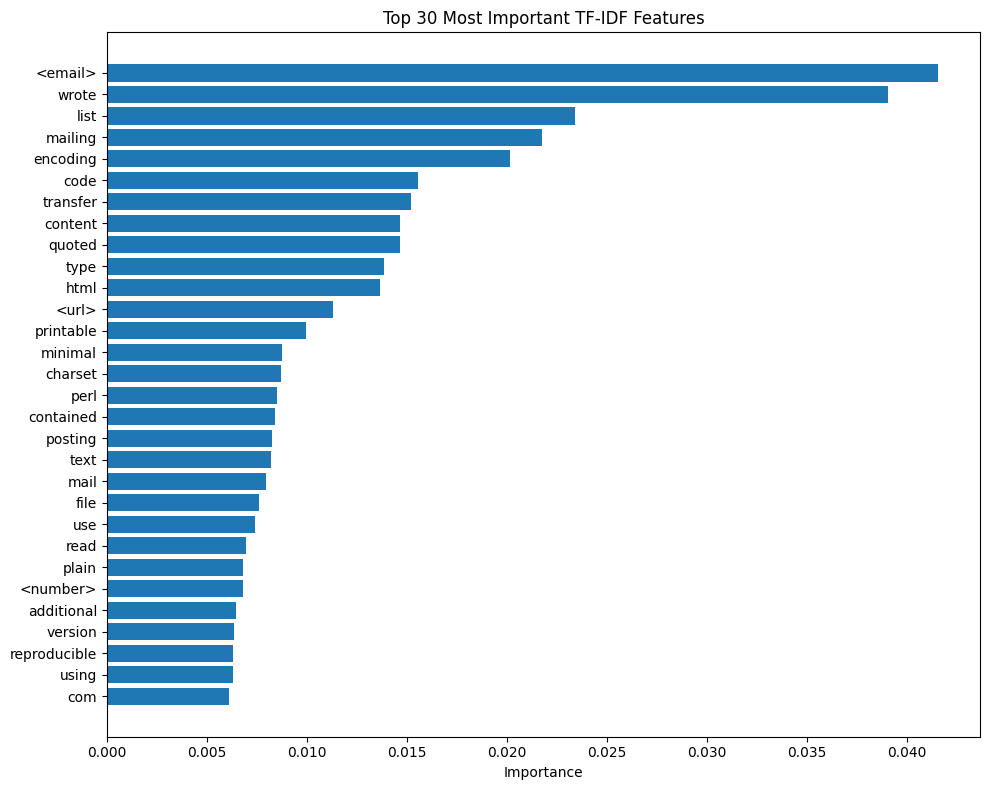

In [ ]:

best_model = joblib.load(os.path.join('Models','trec_final_tfidf_RF.joblib'))
# Extract fitted vectorizer
tfidf = best_model.named_steps['tfidf']
feature_names = tfidf.get_feature_names_out()

importances = best_model.named_steps['clf'].feature_importances_

import pandas as pd

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top_100 = feature_importance_df.head(100)
print(top_100)

import matplotlib.pyplot as plt

top_30 = top_100.head(30)
plt.figure(figsize=(10, 8))
plt.barh(top_30['Feature'][::-1], top_30['Importance'][::-1])
plt.title("Top 30 Most Important TF-IDF Features")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


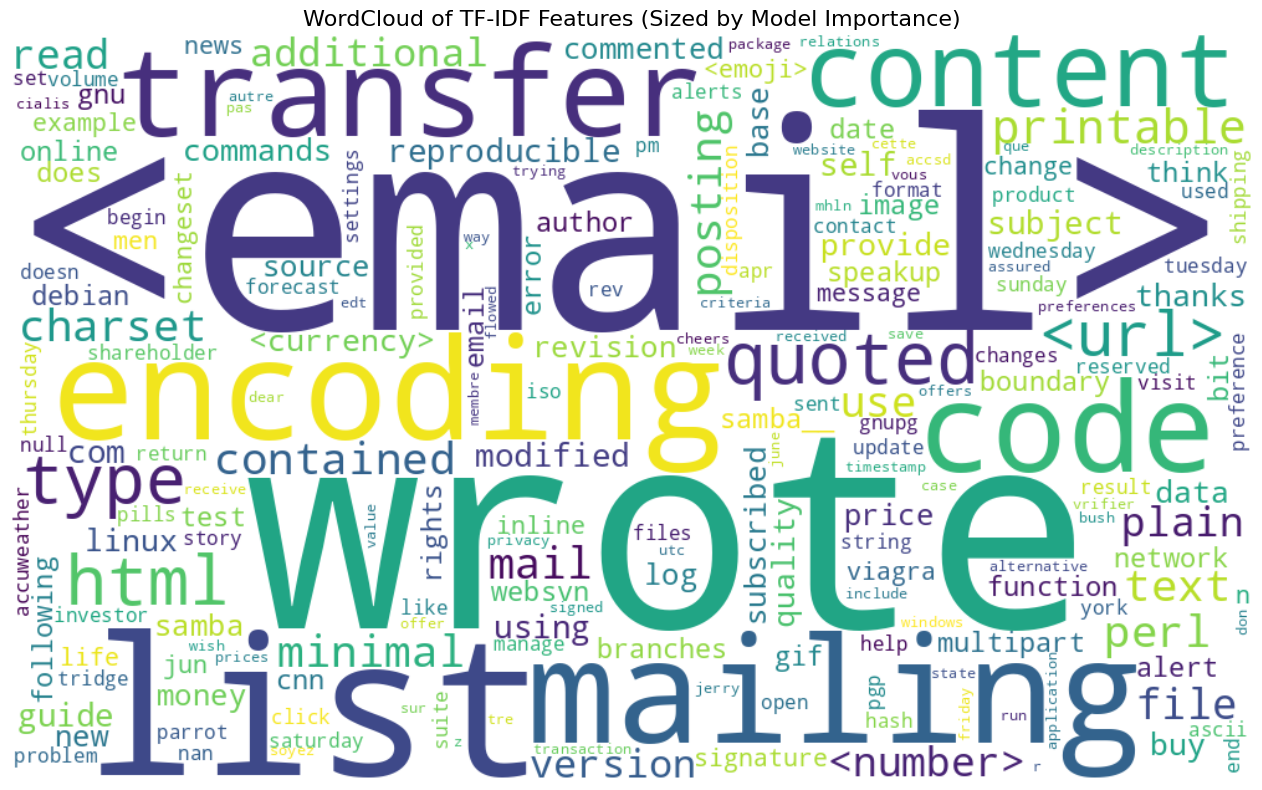

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Extract vectorizer and features
tfidf = best_model.named_steps['tfidf']
feature_names = tfidf.get_feature_names_out()

# Get importances
clf = best_model.named_steps['clf']

# For linear models
import numpy as np
importances = best_model.named_steps['clf'].feature_importances_

# Map feature to importance
feature_importance_dict = dict(zip(feature_names, importances))

# Generate WordCloud from importance scores
wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color='white'
).generate_from_frequencies(feature_importance_dict)

# Plot it
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of TF-IDF Features (Sized by Model Importance)", fontsize=16)
plt.tight_layout()
plt.show()


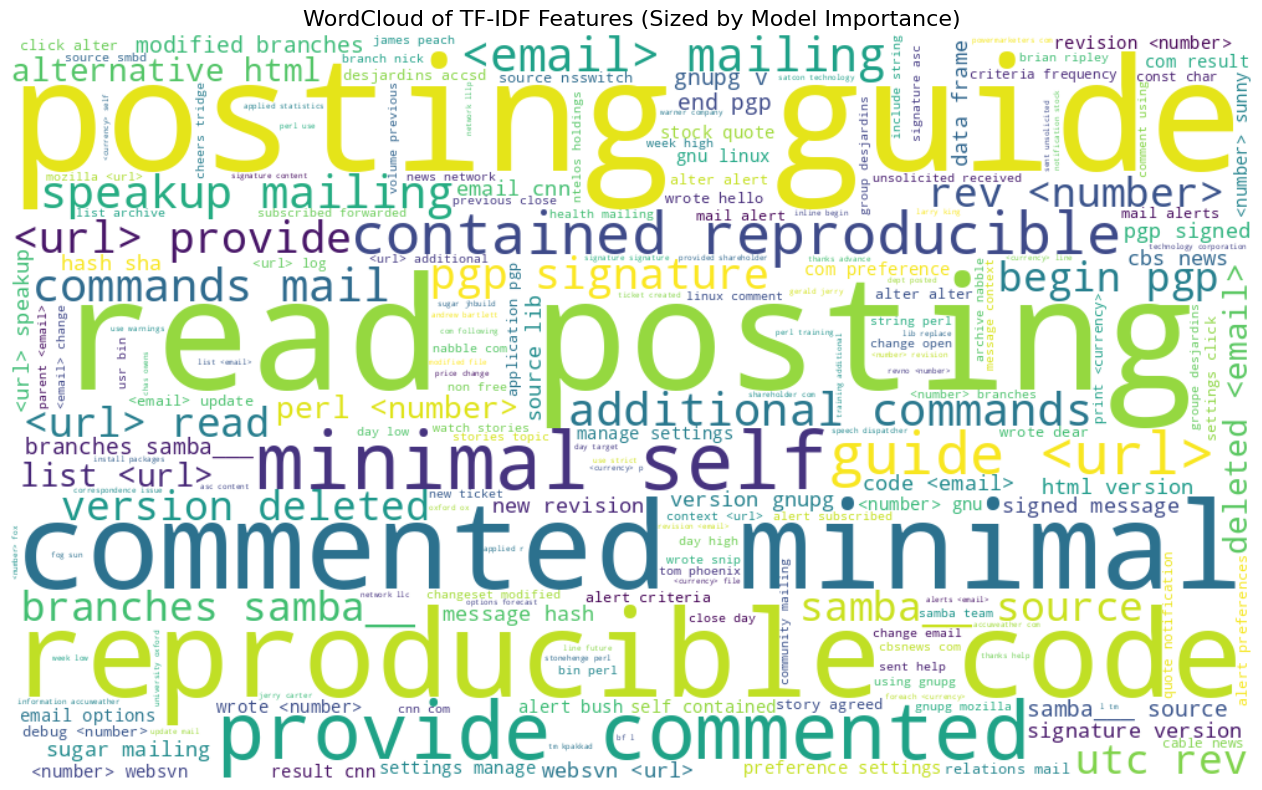

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

best_model = joblib.load(os.path.join('Models','trec_final_features_NB.joblib'))
# Extract vectorizer and features
tfidf = best_model.named_steps['tfidf']
feature_names = tfidf.get_feature_names_out()

# Get class log probabilities from Naive Bayes
clf = best_model.named_steps['clf']
class_log_probs = clf.feature_log_prob_  # shape: [n_classes, n_features]

# Compute importance as absolute difference between class log probs
importances = np.abs(class_log_probs[1] - class_log_probs[0])

# Build feature importance dictionary
feature_importance_dict = dict(zip(feature_names, importances))

# Generate WordCloud from importance scores
wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color='white'
).generate_from_frequencies(feature_importance_dict)

# Plot it
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of TF-IDF Features (Sized by Model Importance)", fontsize=16)
plt.tight_layout()
plt.show()


### Diffusion Models Performance

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch
import numpy as np

# Assume your data
texts = enron_data_final['cleaned_text'].tolist()  # list of email texts
labels = enron_data_final['label'].tolist()        # list or array of 0/1

# Load tokenizer and model
special_tokens =  ['<URL>', '<EMAIL>', '<PHONE>', '<CURRENCY>', '<NUMBER>','<DATE>','<EMOJI>']
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
tokenizer.add_tokens(special_tokens)

encoder = DistilBertModel.from_pretrained("distilbert-base-uncased")
encoder.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = encoder.to(device)


In [ ]:
class DiffusionClassifier(torch.nn.Module):
    def __init__(self, input_dim=768, n_classes=2, timesteps=1000):
        super().__init__()
        self.timesteps = timesteps

        self.denoise_fn = torch.nn.Sequential(
            torch.nn.Linear(input_dim + 1, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, input_dim)
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, n_classes)
        )

    def forward(self, x, t):
        t_embed = t.view(-1, 1).float() / self.timesteps
        x_t = torch.cat([x, t_embed], dim=-1)
        recon = self.denoise_fn(x_t)
        logits = self.classifier(recon)
        return recon, logits


In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch
torch.cuda.empty_cache()


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.cuda.amp import autocast, GradScaler

def train_with_finetune(texts, labels, encoder, tokenizer, epochs=5, batch_size=2, lr=2e-5, timesteps=1000):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    best_f1 = 0
    best_model = None
    scaler = GradScaler()

    for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
        print(f"\n🌀 Fold {fold+1}")
        encoder.train()
        encoder = encoder.to(device)

        model = DiffusionClassifier().to(device)
        optimizer = torch.optim.Adam(list(encoder.parameters()) + list(model.parameters()), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()

        X_train = [texts[i] for i in train_idx]
        y_train = torch.tensor([labels[i] for i in train_idx]).to(device)

        X_val = [texts[i] for i in val_idx]
        y_val = torch.tensor([labels[i] for i in val_idx]).to(device)

        for epoch in range(epochs):
            model.train()
            encoder.train()

            permutation = torch.randperm(len(X_train))
            for i in range(0, len(X_train), batch_size):
                indices = permutation[i:i + batch_size]
                batch_texts = [X_train[j] for j in indices]
                batch_labels = y_train[indices]

                tokens = tokenizer(batch_texts, padding=True, truncation=True, max_length=128, return_tensors='pt')
                tokens = {k: v.to(device) for k, v in tokens.items()}

                with autocast():  # mixed precision context
                    outputs = encoder(**tokens)
                    cls = outputs.last_hidden_state[:, 0, :]  # CLS token

                    t = torch.randint(0, timesteps, (cls.size(0),), device=device)
                    noisy = cls + torch.randn_like(cls) * (1.0 - t.view(-1, 1) / timesteps)

                    recon, logits = model(noisy, t)
                    loss_recon = torch.nn.functional.mse_loss(recon, cls)
                    loss_cls = criterion(logits, batch_labels)
                    loss = loss_cls + loss_recon

                optimizer.zero_grad()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

        # 🧪 Validation
        model.eval()
        encoder.eval()
        with torch.no_grad():
            tokens = tokenizer(X_val, padding=True, truncation=True, max_length=128, return_tensors='pt')
            tokens = {k: v.to(device) for k, v in tokens.items()}
            cls_val = encoder(**tokens).last_hidden_state[:, 0, :]

            t_val = torch.randint(0, timesteps, (cls_val.size(0),), device=device)
            noisy_val = cls_val + torch.randn_like(cls_val) * (1.0 - t_val.view(-1, 1) / timesteps)
            _, val_logits = model(noisy_val, t_val)

            y_pred = torch.argmax(val_logits, dim=1)
            acc = accuracy_score(y_val.cpu(), y_pred.cpu())
            prec = precision_score(y_val.cpu(), y_pred.cpu(), zero_division=0)
            rec = recall_score(y_val.cpu(), y_pred.cpu(), zero_division=0)
            f1 = f1_score(y_val.cpu(), y_pred.cpu())

            print(f"✅ Accuracy : {acc:.4f}")
            print(f"✅ Precision: {prec:.4f}")
            print(f"✅ Recall   : {rec:.4f}")
            print(f"✅ F1 Score : {f1:.4f}")

            if f1 > best_f1:
                best_f1 = f1
                best_model = model

    print(f"\n🏆 Best F1 across folds: {best_f1:.4f}")
    return best_model

best_model = train_with_finetune(texts, labels, encoder, tokenizer)

torch.save({
    "encoder": encoder.state_dict(),
    "classifier": best_model.state_dict()
}, "diffusion_model_finetuned_enron.pth")

best_model

<ipython-input-47-b0520ed1ff8d>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-47-b0520ed1ff8d>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # mixed precision context



🌀 Fold 1


In [ ]:
best_model

In [ ]:


# checkpoint = torch.load("full_model_A.pth")
# encoder.load_state_dict(checkpoint["encoder"])
# best_model.load_state_dict(checkpoint["classifier"])


In [ ]:
X = generate_cls_embeddings(trec_data_final['cleaned_text'].tolist())  # cleaned_text is a list of strings
y = torch.tensor(trec_data_final['label']).numpy()

In [ ]:
import numpy as np

np.savez_compressed("spam_embeddings.npz", X=X, y=y)

In [ ]:
X1 = generate_cls_embeddings(enron_data_final['cleaned_text'].tolist())  # cleaned_text is a list of strings
y1 = torch.tensor(enron_data_final['label']).numpy()

np.savez_compressed("enron_spam_embeddings.npz", X=X1, y=y1)


In [ ]:
X2 = generate_cls_embeddings(spamAssassin_data_final['cleaned_text'].tolist())  # cleaned_text is a list of strings
y2 = torch.tensor(spamAssassin_data_final['label']).numpy()

np.savez_compressed("spamAssasin_spam_embeddings.npz", X=X2, y=y2)

In [ ]:
class DiffusionClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=512, num_classes=2, timesteps=1000):
        super(DiffusionClassifier, self).__init__()
        self.timesteps = timesteps

        self.noise_proj = nn.Linear(input_dim, hidden_dim)
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):  # ⬅️ Removed 't' from here
        noise = torch.randn_like(x) / self.timesteps
        x_noisy = x + noise
        h = self.noise_proj(x_noisy)
        logits = self.classifier(h)
        return logits


In [ ]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# def train_diffusion_model(X, y, input_dim=768, epochs=10, batch_size=32, lr=1e-4, timesteps=1000):
#     import torch
#     import numpy as np
#     from sklearn.model_selection import StratifiedKFold

#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     best_f1 = 0
#     best_model = None

#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#     for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
#         print(f"\n🌀 Fold {fold + 1}")

#         model = DiffusionClassifier(input_dim=input_dim, n_classes=2, timesteps=timesteps).to(device)
#         optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#         criterion = torch.nn.CrossEntropyLoss()

#         X_train = torch.tensor(X[train_idx], dtype=torch.float32).to(device)
#         y_train = torch.tensor(y[train_idx], dtype=torch.long).to(device)
#         X_val = torch.tensor(X[val_idx], dtype=torch.float32).to(device)
#         y_val = torch.tensor(y[val_idx], dtype=torch.long).to(device)

#         for epoch in range(epochs):
#             model.train()
#             permutation = torch.randperm(X_train.size(0))

#             for i in range(0, X_train.size(0), batch_size):
#                 indices = permutation[i:i + batch_size]
#                 batch_x, batch_y = X_train[indices], y_train[indices]

#                 t = torch.randint(0, timesteps, (batch_x.size(0),), device=device)

#                 noisy_x = batch_x + torch.randn_like(batch_x) * (1.0 - t.view(-1, 1) / timesteps)
#                 recon_x, logits = model(noisy_x, t)

#                 loss_recon = torch.nn.functional.mse_loss(recon_x, batch_x)
#                 loss_cls = criterion(logits, batch_y)
#                 loss = loss_cls + loss_recon

#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#         # 🧪 Validation
#         model.eval()
#         with torch.no_grad():
#             t_val = torch.randint(0, timesteps, (X_val.size(0),), device=device)
#             noisy_val = X_val + torch.randn_like(X_val) * (1.0 - t_val.view(-1, 1) / timesteps)
#             _, val_logits = model(noisy_val, t_val)

#             y_true = y_val.cpu().numpy()
#             y_pred = torch.argmax(val_logits, dim=1).cpu().numpy()

#             acc = accuracy_score(y_true, y_pred)
#             precision = precision_score(y_true, y_pred, zero_division=0)
#             recall = recall_score(y_true, y_pred, zero_division=0)
#             f1 = f1_score(y_true, y_pred)

#             print(f"✅ Fold {fold + 1} Metrics:")
#             print(f"   Accuracy : {acc:.4f}")
#             print(f"   Precision: {precision:.4f}")
#             print(f"   Recall   : {recall:.4f}")
#             print(f"   F1-Score : {f1:.4f}")

#             if f1 > best_f1:
#                 best_f1 = f1
#                 best_model = model

#     print(f"\n🏆 Best F1 Score across folds: {best_f1:.4f}")
#     return best_model


In [ ]:
import torch
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from tqdm import tqdm

def train_diffusion_model_partial_ft(texts, labels, encoder, tokenizer, epochs=5, batch_size=8, lr=2e-5, timesteps=1000):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    best_f1 = 0.0
    best_model_state = None

    # PARTIAL FINE-TUNING: Freeze all encoder params
    for param in encoder.parameters():
        param.requires_grad = False

    # Unfreeze last few layers (example: last encoder layer and pooler if exists)
    for name, param in encoder.named_parameters():
        if "encoder.layer.11" in name or "pooler" in name:
            param.requires_grad = True

    for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
        print(f"\n🌀 Fold {fold+1}")

        # Create new classifier each fold
        model = DiffusionClassifier(timesteps=timesteps).to(device)
        encoder.to(device)

        optimizer = torch.optim.Adam(
            list(filter(lambda p: p.requires_grad, encoder.parameters())) + list(model.parameters()),
            lr=lr
        )
        criterion = nn.CrossEntropyLoss()

        X_train = [texts[i] for i in train_idx]
        y_train = [labels[i] for i in train_idx]
        X_val = [texts[i] for i in val_idx]
        y_val = [labels[i] for i in val_idx]

        for epoch in range(epochs):
            model.train()
            encoder.train()
            epoch_loss = 0.0

            for i in range(0, len(X_train), batch_size):
                batch_texts = X_train[i:i+batch_size]
                batch_labels = torch.tensor(y_train[i:i+batch_size]).to(device)

                # Tokenize and get embeddings
                encoded = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True)
                input_ids = encoded['input_ids'].to(device)
                attention_mask = encoded['attention_mask'].to(device)
                with torch.no_grad():
                    embeddings = encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]

                # Forward through DiffusionClassifier
                outputs = model(embeddings)
                loss = criterion(outputs, batch_labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        encoder.eval()
        y_preds, y_true = [], []

        with torch.no_grad():
            for i in range(0, len(X_val), batch_size):
                batch_texts = X_val[i:i+batch_size]
                batch_labels = y_val[i:i+batch_size]

                encoded = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True)
                input_ids = encoded['input_ids'].to(device)
                attention_mask = encoded['attention_mask'].to(device)

                embeddings = encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
                outputs = model(embeddings)
                preds = torch.argmax(outputs, dim=1).cpu().numpy()

                y_preds.extend(preds)
                y_true.extend(batch_labels)

        f1 = f1_score(y_true, y_preds, average='macro')
        print(f"Fold {fold+1} F1 Score: {f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_model_state = {
                "model": model.state_dict(),
                "encoder": encoder.state_dict(),
                "f1": f1
            }

    print(f"\n🏆 Best Validation F1: {best_f1:.4f}")
    return best_model_state

best_model = train_diffusion_model_partial_ft(texts, labels, encoder, tokenizer)

torch.save({
    "encoder": encoder.state_dict(),
    "classifier": best_model.state_dict()
}, "diffusion_model_partial_finetuned_enron.pth")

best_model



🌀 Fold 1
Epoch 1/5, Loss: 1045.9761
Epoch 2/5, Loss: 643.9369
Epoch 3/5, Loss: 483.1771
Epoch 4/5, Loss: 412.9110
Epoch 5/5, Loss: 376.1296
Fold 1 F1 Score: 0.6104

🌀 Fold 2
Epoch 1/5, Loss: 1046.8981
Epoch 2/5, Loss: 643.0527
Epoch 3/5, Loss: 480.0081
Epoch 4/5, Loss: 412.9439
Epoch 5/5, Loss: 377.6571
Fold 2 F1 Score: 0.6262

🌀 Fold 3
Epoch 1/5, Loss: 1044.8432
Epoch 2/5, Loss: 642.9555
Epoch 3/5, Loss: 473.0874
Epoch 4/5, Loss: 406.3865
Epoch 5/5, Loss: 375.3532
Fold 3 F1 Score: 0.6148

🌀 Fold 4
Epoch 1/5, Loss: 1063.0798
Epoch 2/5, Loss: 656.3485
Epoch 3/5, Loss: 488.9271
Epoch 4/5, Loss: 418.6166
Epoch 5/5, Loss: 377.0816
Fold 4 F1 Score: 0.6010

🌀 Fold 5
Epoch 1/5, Loss: 1052.9217


KeyboardInterrupt: 

In [ ]:
data = np.load("spam_embeddings.npz")
X = data['X']
y = data['y']

best_model = train_diffusion_model(X, y, input_dim=768, epochs=10)


🌀 Fold 1
✅ Fold 1 Metrics:
   Accuracy : 0.8972
   Precision: 0.9162
   Recall   : 0.9307
   F1-Score : 0.9234

🌀 Fold 2
✅ Fold 2 Metrics:
   Accuracy : 0.8960
   Precision: 0.9045
   Recall   : 0.9433
   F1-Score : 0.9235

🌀 Fold 3
✅ Fold 3 Metrics:
   Accuracy : 0.9010
   Precision: 0.9095
   Recall   : 0.9454
   F1-Score : 0.9271

🌀 Fold 4
✅ Fold 4 Metrics:
   Accuracy : 0.9010
   Precision: 0.9152
   Recall   : 0.9381
   F1-Score : 0.9265

🌀 Fold 5
✅ Fold 5 Metrics:
   Accuracy : 0.8976
   Precision: 0.9036
   Recall   : 0.9471
   F1-Score : 0.9249

🏆 Best F1 Score across folds: 0.9271


In [ ]:
torch.save(best_model.state_dict(), "best_diffusion_model.pth")

## Zero-Shot learning Performance

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch

# Load tokenizer with any added tokens
special_tokens = ['<URL>', '<EMAIL>', '<PHONE>', '<CURRENCY>', '<NUMBER>']
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
tokenizer.add_tokens(special_tokens)

# Reinitialize encoder
encoder = DistilBertModel.from_pretrained("distilbert-base-uncased")
encoder.resize_token_embeddings(len(tokenizer))

# Reinitialize classifier
model = DiffusionClassifier(input_dim=768, n_classes=2, timesteps=1000)

encoder.load_state_dict(torch.load("encoder_A.pth"))
model.load_state_dict(torch.load("diffusion_classifier_A.pth"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = encoder.to(device).eval()
model = model.to(device).eval()

def get_cls_embeddings(texts, tokenizer, encoder, batch_size=64, max_len=128):
    all_embeddings = []
    encoder.eval()

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        tokens = tokenizer(batch, padding=True, truncation=True, max_length=max_len, return_tensors="pt")
        tokens = {k: v.to(device) for k, v in tokens.items()}

        with torch.no_grad():
            output = encoder(**tokens)
            cls_emb = output.last_hidden_state[:, 0, :]  # CLS token
            all_embeddings.append(cls_emb.cpu())

    return torch.cat(all_embeddings, dim=0)

X_B = get_cls_embeddings(cleaned_text_B, tokenizer, encoder)

timesteps = 1000
X_B = X_B.to(device)
t = torch.randint(0, timesteps, (X_B.size(0),), device=device)
X_noisy = X_B + torch.randn_like(X_B) * (1.0 - t.view(-1, 1) / timesteps)

with torch.no_grad():
    _, logits = model(X_noisy, t)
    y_pred = torch.argmax(logits, dim=1)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = torch.tensor(labels_B).cpu().numpy()
y_pred = y_pred.cpu().numpy()

print("📊 Zero-shot Evaluation on Dataset B:")
print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall   : {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score : {f1_score(y_true, y_pred):.4f}")


## Diffusion Model validation on other datasets

In [ ]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Load saved model
model = DiffusionClassifier(input_dim=768, n_classes=2, timesteps=1000)
model.load_state_dict(torch.load("best_diffusion_model.pth"))
model.eval()
model.to("cuda" if torch.cuda.is_available() else "cpu")

# Prepare new data
data = np.load("enron_spam_embeddings.npz")
X_new = data['X']
y_new = data['y']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor = torch.tensor(X_new, dtype=torch.float32).to(device)

# Simulate noise
timesteps = 1000
t = torch.randint(0, timesteps, (X_tensor.size(0),), device=device)
noisy_X = X_tensor + torch.randn_like(X_tensor) * (1.0 - t.view(-1, 1) / timesteps)

# Get predictions
model.eval()
with torch.no_grad():
    _, logits = model(noisy_X, t)
    y_pred = torch.argmax(logits, dim=1).cpu().numpy()

# Calculate metrics
precision = precision_score(y_new, y_pred, zero_division=0)
recall = recall_score(y_new, y_pred, zero_division=0)
f1 = f1_score(y_new, y_pred)
acc = accuracy_score(y_new, y_pred)

print("📊 Evaluation on New Dataset:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


📊 Evaluation on New Dataset:
Accuracy : 0.5996
Precision: 0.5647
Recall   : 0.9071
F1 Score : 0.6961


In [ ]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Load saved model
model = DiffusionClassifier(input_dim=768, n_classes=2, timesteps=1000)
model.load_state_dict(torch.load("best_diffusion_model.pth"))
model.eval()
model.to("cuda" if torch.cuda.is_available() else "cpu")

# Prepare new data
data = np.load("spamAssasin_spam_embeddings.npz")
X_new = data['X']
y_new = data['y']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor = torch.tensor(X_new, dtype=torch.float32).to(device)

# Simulate noise
timesteps = 1000
t = torch.randint(0, timesteps, (X_tensor.size(0),), device=device)
noisy_X = X_tensor + torch.randn_like(X_tensor) * (1.0 - t.view(-1, 1) / timesteps)

# Get predictions
model.eval()
with torch.no_grad():
    _, logits = model(noisy_X, t)
    y_pred = torch.argmax(logits, dim=1).cpu().numpy()

# Calculate metrics
precision = precision_score(y_new, y_pred, zero_division=0)
recall = recall_score(y_new, y_pred, zero_division=0)
f1 = f1_score(y_new, y_pred)
acc = accuracy_score(y_new, y_pred)

print("📊 Evaluation on New Dataset:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


📊 Evaluation on New Dataset:
Accuracy : 0.7015
Precision: 0.5497
Recall   : 0.8545
F1 Score : 0.6690


### Distribution Shift Analysis

In [49]:
spamAssassin_data_final.head(1)

source  \
0  spamAssassin   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   message  \
0  "\n> From: fork-admin@xent.com [mailto:fork-admin@xent.com] On Behalf Of\nJames\n> Rogers\n\n> Subject: Re: The Curse of India's Socialism\n> \n> On Tue, 2002-08-20 at 15:01, Ian Andrew Bell wrote:\n\n> > They\n> > finished their routine with the a quadruple lutz -- laying off\n> > hundreds of thousands of workers when it all came crashing down.\n> \n> So what?  Nobody is guaranteed employment.  Laying people off is not a\n> crime nor is it immoral.  Companies don't exist to provide employment,\n> nor should they.  The closest we have to such a thing in the US is a\n> Government Job, and look at the quality THAT breeds.\n\nAnd further, why focus on the fact they were laid off and not on the\nfact they were hired in the first place?\n\nBTW: I saw someone claim that aside from the efficiency of the market\nthere were also gains to society from irrational behavior.\n\nIf a society has business people that systematically overestimate their\nchances, that is bad for the businessmen but on net a big gain for\nsociety.  On the social level, the law of averages works to societies\nbenefit in a manner it can't for an individual.\n\nA key reason, in this view, that the US wound up outperforming England\nwas that the English investors were too rational for their societies own\ngood.\n\n(Except, of course, when US investors were bilking them to build canals\nand railroads over here.  Thanks, guys.)\n\n=====================\n\nApplied to telecom: a lot of dark wire (glass) and innovation will\neventually be used for pennies on the dollar, the benefits to society\nand the costs to the investors.\n\n\n\n\n\n\n"   

   label  \
0      0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [21]:
def stratified_sample(df, label_col='label', n=10000, seed=42):
    # Determine proportion of each class
    class_counts = df[label_col].value_counts(normalize=True)
    samples = []

    for label, frac in class_counts.items():
        label_df = df[df[label_col] == label]
        sample_n = int(n * frac)
        samples.append(label_df.sample(n=min(sample_n, len(label_df)), random_state=seed))

    return pd.concat(samples)

# Apply to your datasets
sample_n = 10000  # total samples per dataset


trec_data_final_down = stratified_sample(trec_data_final, label_col='label', n=sample_n)
enron_data_final_down = stratified_sample(enron_data_final, label_col='label', n=sample_n)
spamAssassin_data_final_down = stratified_sample(spamAssassin_data_final, label_col='label', n=sample_n)

print("Dataset A:", trec_data_final_down['label'].value_counts(normalize=True))
print("Dataset B:", enron_data_final_down['label'].value_counts(normalize=True))
print("Dataset C:", spamAssassin_data_final_down['label'].value_counts(normalize=True))

Dataset A: label
1    0.665667
0    0.334333
Name: proportion, dtype: float64
Dataset B: label
1    0.505351
0    0.494649
Name: proportion, dtype: float64
Dataset C: label
0    0.646965
1    0.353035
Name: proportion, dtype: float64


In [51]:
combined_df = pd.concat([trec_data_final_down, enron_data_final_down, spamAssassin_data_final_down], ignore_index=True)

# Sanity check
assert 'cleaned_text' in combined_df.columns
assert 'label' in combined_df.columns
assert 'source' in combined_df.columns  # A/B/C

texts = combined_df["cleaned_text"].astype(str)
labels = combined_df["label"]
sources = combined_df["source"]



In [52]:
tfidf_combined = TfidfVectorizer(
    max_features=3000,
    token_pattern=r'<[^>]+>|\b\w+\b',
    lowercase=True
)
X_tfidf = tfidf_combined.fit_transform(texts)

from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    random_state=42
)
X_tsne = tsne.fit_transform(X_tfidf.toarray())


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


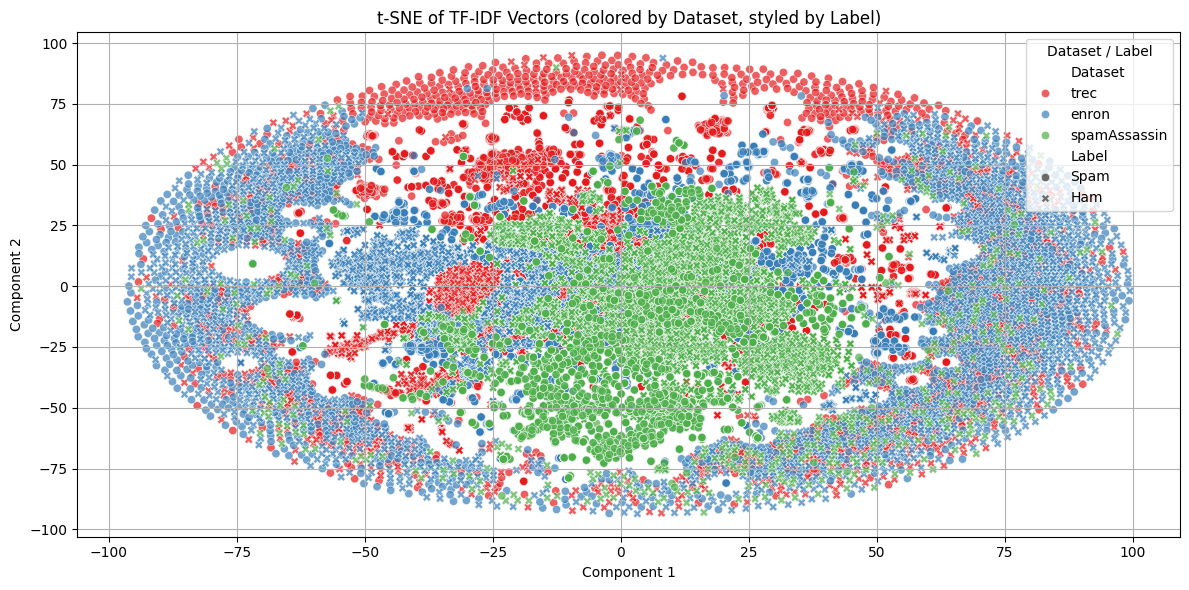

In [53]:
tsne_df = pd.DataFrame({
    "tsne_1": X_tsne[:, 0],
    "tsne_2": X_tsne[:, 1],
    "Dataset": sources,
    "Label": labels.map({0: "Ham", 1: "Spam"})  # Make labels human-readable
})

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=tsne_df,
    x="tsne_1", y="tsne_2",
    hue="Dataset",
    style="Label",
    alpha=0.7,
    palette="Set1"
)
plt.title("t-SNE of TF-IDF Vectors (colored by Dataset, styled by Label)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Dataset / Label")
plt.grid(True)
plt.tight_layout()
plt.show()


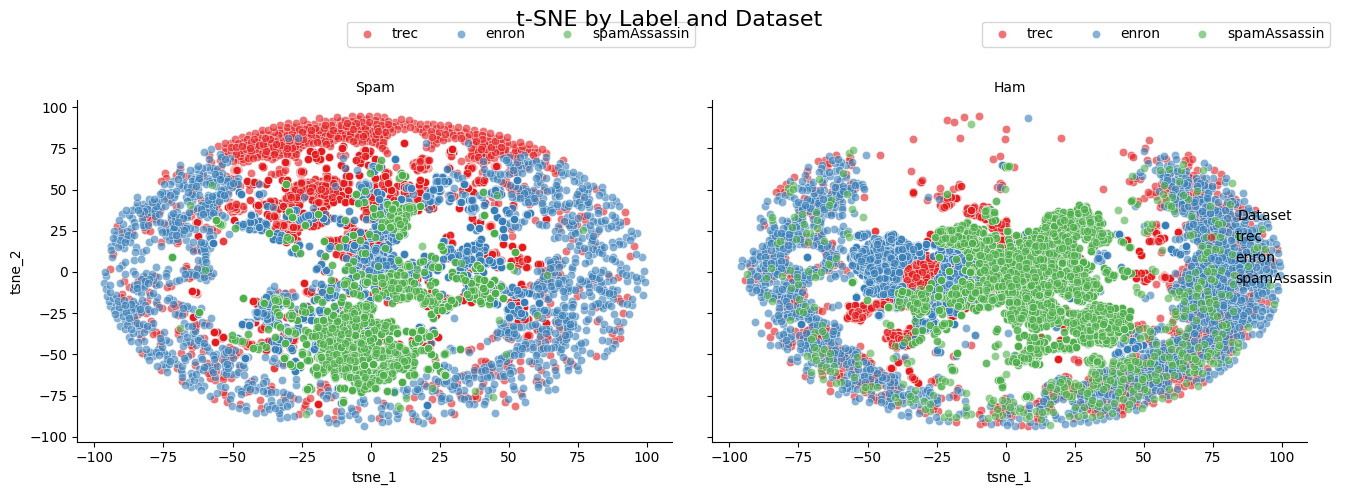

In [55]:
g = sns.FacetGrid(tsne_df, col="Label", hue="Dataset", height=5, aspect=1.2, palette="Set1")
g.map_dataframe(sns.scatterplot, x="tsne_1", y="tsne_2", alpha=0.6)
g.add_legend(title="Dataset")

# Customize legend position and layout
for ax in g.axes.flat:
    ax.legend(loc='upper right', bbox_to_anchor=(1.05, 1.25), ncol=len(tsne_df['Dataset'].unique()))

g.set_titles(col_template="{col_name}")
g.fig.suptitle("t-SNE by Label and Dataset", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.8)
plt.show()


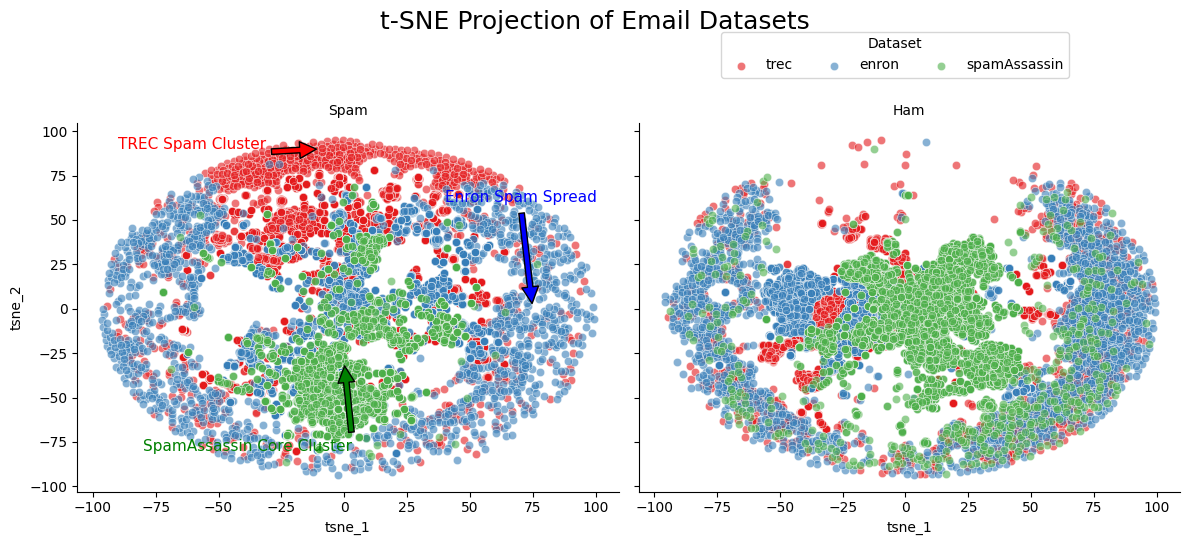

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the t-SNE FacetGrid
g = sns.FacetGrid(tsne_df, col="Label", hue="Dataset", height=5, aspect=1.2, palette="Set1", legend_out=True)
g.map_dataframe(sns.scatterplot, x="tsne_1", y="tsne_2", alpha=0.6)

# Add shared legend on top right in one row
handles, labels = g.axes[0, 0].get_legend_handles_labels()
g.fig.legend(handles=handles, labels=labels, title="Dataset",
             loc='upper center', bbox_to_anchor=(0.75, 1.05), ncol=len(labels))

# Add annotations for Spam cluster (left plot)
spam_ax = g.axes[0, 0]
spam_ax.annotate("TREC Spam Cluster", xy=(-10, 90), xytext=(-90, 90),
                 arrowprops=dict(facecolor='red', shrink=0.05), fontsize=11, color='red')

spam_ax.annotate("Enron Spam Spread", xy=(75, 0), xytext=(40, 60),
                 arrowprops=dict(facecolor='blue', shrink=0.05), fontsize=11, color='blue')

spam_ax.annotate("SpamAssassin Core Cluster", xy=(0, -30), xytext=(-80, -80),
                 arrowprops=dict(facecolor='green', shrink=0.05), fontsize=11, color='green')

# Title and layout
g.set_titles(col_template="{col_name}")
g.fig.suptitle("t-SNE Projection of Email Datasets", fontsize=18, y=1.08)
g.fig.subplots_adjust(top=0.9)
plt.tight_layout()
plt.show()


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Combine all texts to fit a shared vocabulary
all_texts = pd.concat([trec_data_final_down['cleaned_text'], enron_data_final_down['cleaned_text'], spamAssassin_data_final_down['cleaned_text']]).astype(str)

# Fit shared TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=3000,
    token_pattern=r'<[^>]+>|\b\w+\b',
    lowercase=True
)
vectorizer.fit(all_texts)

# Transform each dataset separately
X_a = vectorizer.transform(trec_data_final_down['cleaned_text'].astype(str))
X_b = vectorizer.transform(enron_data_final_down['cleaned_text'].astype(str))
X_c = vectorizer.transform(spamAssassin_data_final_down['cleaned_text'].astype(str))


In [24]:
import numpy as np

# Get average TF-IDF vectors for each dataset
p_a = np.asarray(X_a.mean(axis=0)).flatten()
p_b = np.asarray(X_b.mean(axis=0)).flatten()
p_c = np.asarray(X_c.mean(axis=0)).flatten()


In [25]:
from scipy.spatial.distance import cosine
from scipy.special import rel_entr

def normalize(p):
    p = p + 1e-10  # prevent log(0)
    return p / p.sum()

def kl(p, q):
    return np.sum(rel_entr(normalize(p), normalize(q)))

def cosine_dist(p, q):
    return cosine(p, q)


In [26]:
print("KL Divergences:")
print("A → B:", kl(p_a, p_b))
print("A → C:", kl(p_a, p_c))
print("B → C:", kl(p_b, p_c))

print("\nCosine Distances:")
print("A ↔ B:", cosine_dist(p_a, p_b))
print("A ↔ C:", cosine_dist(p_a, p_c))
print("B ↔ C:", cosine_dist(p_b, p_c))


KL Divergences:
A → B: 1.6639453433489941
A → C: 1.3889154888147837
B → C: 1.067703901105506

Cosine Distances:
A ↔ B: 0.250405173888566
A ↔ C: 0.22579628269059593
B ↔ C: 0.19378450590011853


## Cross-Domain Model Performance Analysis

In [14]:
import os
import joblib

In [19]:
trec_best_model_SVM = joblib.load(os.path.join('Models','trec_final_tfidf_SVM.joblib'))

enron_data_final = enron_data_final.dropna()
enron_data_final = enron_data_final.reset_index(drop=True)

y_actual = enron_data_final['label']
y_pred = trec_best_model_SVM.predict(enron_data_final['cleaned_text'])

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

precision = precision_score(y_actual, y_pred)
recall = recall_score(y_actual, y_pred)
f1 = f1_score(y_actual, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.7478
Recall: 0.8882
F1 Score: 0.8120


In [21]:
trec_best_model_SVM = joblib.load(os.path.join('Models','trec_final_tfidf_SVM.joblib'))

spamAssassin_data_final = spamAssassin_data_final.dropna()
spamAssassin_data_final = spamAssassin_data_final.reset_index(drop=True)

y_actual = spamAssassin_data_final['label']
y_pred = trec_best_model_SVM.predict(spamAssassin_data_final['cleaned_text'])

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

precision = precision_score(y_actual, y_pred)
recall = recall_score(y_actual, y_pred)
f1 = f1_score(y_actual, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.6246
Recall: 0.7920
F1 Score: 0.6984


In [23]:
enron_best_model_SVM = joblib.load(os.path.join('Models/Naveen_Models','enron_bigrams_SVM.joblib'))

trec_data_final = trec_data_final.dropna()
trec_data_final = trec_data_final.reset_index(drop=True)

y_actual = trec_data_final['label']
y_pred = enron_best_model_SVM.predict(trec_data_final['cleaned_text'])

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

precision = precision_score(y_actual, y_pred)
recall = recall_score(y_actual, y_pred)
f1 = f1_score(y_actual, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.7042
Recall: 0.9933
F1 Score: 0.8241


In [24]:
enron_best_model_SVM = joblib.load(os.path.join('Models/Naveen_Models','enron_bigrams_SVM.joblib'))

spamAssassin_data_final = spamAssassin_data_final.dropna()
spamAssassin_data_final = spamAssassin_data_final.reset_index(drop=True)

y_actual = spamAssassin_data_final['label']
y_pred = enron_best_model_SVM.predict(spamAssassin_data_final['cleaned_text'])

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

precision = precision_score(y_actual, y_pred)
recall = recall_score(y_actual, y_pred)
f1 = f1_score(y_actual, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.4257
Recall: 0.9863
F1 Score: 0.5947


In [26]:
spamassassin_best_model_SVM = joblib.load(os.path.join('Models/Naveen_Models','spam_assassin_bigrams_SVM.joblib'))

trec_data_final = trec_data_final.dropna()
trec_data_final = trec_data_final.reset_index(drop=True)

y_actual = trec_data_final['label']
y_pred = spamassassin_best_model_SVM.predict(trec_data_final['cleaned_text'])

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

precision = precision_score(y_actual, y_pred)
recall = recall_score(y_actual, y_pred)
f1 = f1_score(y_actual, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9254
Recall: 0.5953
F1 Score: 0.7245


In [27]:
spamassassin_best_model_SVM = joblib.load(os.path.join('Models/Naveen_Models','spam_assassin_bigrams_SVM.joblib'))

enron_data_final = enron_data_final.dropna()
enron_data_final = enron_data_final.reset_index(drop=True)

y_actual = enron_data_final['label']
y_pred = spamassassin_best_model_SVM.predict(enron_data_final['cleaned_text'])

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

precision = precision_score(y_actual, y_pred)
recall = recall_score(y_actual, y_pred)
f1 = f1_score(y_actual, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.7970
Recall: 0.5844
F1 Score: 0.6744


### Diffusion Classifier

In [13]:
!pip install transformers

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np


In [23]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
encoder = DistilBertModel.from_pretrained("distilbert-base-uncased")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [24]:
class DiffusionClassifier(nn.Module):
    def __init__(self, embedding_dim=768, num_classes=2):
        super(DiffusionClassifier, self).__init__()
        self.denoise = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, embedding_dim)
        )
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def forward(self, x_noisy, t):
        x_denoised = self.denoise(x_noisy)
        logits = self.classifier(x_denoised)
        return x_denoised, logits


In [25]:
def embed_texts(texts, tokenizer, encoder, device='cuda'):
    tokenizer_out = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=128)
    tokenizer_out = {k: v.to(device) for k, v in tokenizer_out.items()}
    with torch.no_grad():
        outputs = encoder(**tokenizer_out)
        embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
    return embeddings


In [26]:
device

'cuda'

In [30]:
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

def train_diffusion_model(texts, labels, tokenizer, encoder, epochs=5, batch_size=2, timesteps=1000, device='cuda'):
    encoder = encoder.to(device)
    model = DiffusionClassifier().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    best_f1 = 0
    best_model = None

    for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
        print(f"\n🔁 Fold {fold+1}")
        model.train()

        X_train = [texts[i] for i in train_idx]
        y_train = torch.tensor([labels[i] for i in train_idx]).to(device)
        X_val = [texts[i] for i in val_idx]
        y_val = torch.tensor([labels[i] for i in val_idx]).to(device)

        for epoch in range(epochs):
          permutation = torch.randperm(len(X_train))
          for i in range(0, len(X_train), batch_size):
              indices = permutation[i:i + batch_size]
              batch_texts = [X_train[j] for j in indices]
              batch_labels = y_train[indices]

              embeddings = embed_texts(batch_texts, tokenizer, encoder, device).detach()
              t = torch.randint(0, timesteps, (embeddings.size(0),), device=device)
              noisy = embeddings + torch.randn_like(embeddings) * (1.0 - t.view(-1, 1) / timesteps)

              with autocast():
                  recon, logits = model(noisy, t)
                  loss_recon = F.mse_loss(recon, embeddings)
                  loss_cls = criterion(logits, batch_labels)
                  loss = loss_cls + loss_recon

              optimizer.zero_grad()
              scaler.scale(loss).backward()
              scaler.step(optimizer)
              scaler.update()

              # Cleanup
              del embeddings, noisy, recon, logits, batch_labels
              torch.cuda.empty_cache()

        # Validation
        model.eval()
        with torch.no_grad():
            val_embeddings = embed_texts(X_val, tokenizer, encoder, device)
            t_val = torch.randint(0, timesteps, (val_embeddings.size(0),), device=device)
            noise_val = torch.randn_like(val_embeddings) * (1.0 - t_val.view(-1, 1) / timesteps)
            noisy_val = val_embeddings + noise_val
            _, logits_val = model(noisy_val, t_val)

            y_pred = torch.argmax(logits_val, dim=1)
            acc = accuracy_score(y_val.cpu(), y_pred.cpu())
            prec = precision_score(y_val.cpu(), y_pred.cpu())
            rec = recall_score(y_val.cpu(), y_pred.cpu())
            f1 = f1_score(y_val.cpu(), y_pred.cpu())

            print(f"✅ Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")

            if f1 > best_f1:
                best_f1 = f1
                best_model = model

    print(f"\n🏆 Best F1 across folds: {best_f1:.4f}")
    return best_model


<ipython-input-30-172112fbc800>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
# Example: Use one of your datasets
enron_data_final_down = enron_data_final_down.dropna()
enron_data_final_down = enron_data_final_down.reset_index(drop=True)

texts = enron_data_final_down['cleaned_text'].tolist()  # Replace NaNs with empty strings
labels = enron_data_final_down['label'].tolist()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

best_model = train_diffusion_model(texts, labels, tokenizer, encoder, device=device)



🔁 Fold 1


<ipython-input-30-172112fbc800>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


✅ Accuracy: 0.8150, Precision: 0.8239, Recall: 0.8059, F1 Score: 0.8148

🔁 Fold 2


<ipython-input-30-172112fbc800>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


✅ Accuracy: 0.8255, Precision: 0.8151, Recall: 0.8465, F1 Score: 0.8305

🔁 Fold 3


<ipython-input-30-172112fbc800>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


✅ Accuracy: 0.8220, Precision: 0.8531, Recall: 0.7822, F1 Score: 0.8161

🔁 Fold 4


<ipython-input-30-172112fbc800>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


✅ Accuracy: 0.8125, Precision: 0.8250, Recall: 0.7980, F1 Score: 0.8113

🔁 Fold 5


<ipython-input-30-172112fbc800>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


In [32]:
def stratified_sample(df, label_col='label', n=10000, seed=42):
    # Determine proportion of each class
    class_counts = df[label_col].value_counts(normalize=True)
    samples = []

    for label, frac in class_counts.items():
        label_df = df[df[label_col] == label]
        sample_n = int(n * frac)
        samples.append(label_df.sample(n=min(sample_n, len(label_df)), random_state=seed))

    return pd.concat(samples)

# Apply to your datasets
sample_n = 10000  # total samples per dataset


trec_data_final_down = stratified_sample(trec_data_final, label_col='label', n=sample_n)
enron_data_final_down = stratified_sample(enron_data_final, label_col='label', n=sample_n)
spamAssassin_data_final_down = stratified_sample(spamAssassin_data_final, label_col='label', n=sample_n)

print("Dataset A:", trec_data_final_down['label'].value_counts(normalize=True))
print("Dataset B:", enron_data_final_down['label'].value_counts(normalize=True))
print("Dataset C:", spamAssassin_data_final_down['label'].value_counts(normalize=True))

Dataset A: label
1    0.665667
0    0.334333
Name: proportion, dtype: float64
Dataset B: label
1    0.50495
0    0.49505
Name: proportion, dtype: float64
Dataset C: label
0    0.646965
1    0.353035
Name: proportion, dtype: float64
